# Zero-shot with scGPT

In this notebook, the pre-trained version of scGPT (specifically, scGPT-human) will be used to generate cell embeddings for the various datasets. A clustering algorithm, as well as a feed-forward neural network, will then be used to judge the quality of these embeddings in discerning the data and its labels (either cell types or cell states as explained in the thesis).

## Import scGPT and dependencies

In [1]:
from pathlib import Path
import warnings

import scanpy as sc
import scib
import numpy as np
import sys
import torch

sys.path.insert(0, "../")

import scgpt as scg
import matplotlib.pyplot as plt
import anndata

plt.style.context('default')
warnings.simplefilter("ignore", ResourceWarning)

model_dir = Path("/home/andreafabbricatore/thesis/scgpt/scGPT/save/scGPT_human")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/andreafabbricatore/.local/lib/python3.10/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/andreafabbricatore/.local/lib/python3.10/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/andreafabbricatore/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# FOETAL

## Prepare the datasets

In [2]:
#foetal
smaple_data_path = '/home/andreafabbricatore/thesis/data/foetal_filtered.h5ad'
adata = sc.read_h5ad(smaple_data_path)
adata.var['gene_name'] = adata.var.index

gene_col = "gene_name"
cell_type_key = "Label_merged"
batch_key = "sample"
N_HVG = 3000

## Generate the cell embeddings

In [3]:
embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)
# attach the cell embedding to the original adata

scGPT - INFO - match 20856/29680 genes in vocabulary of size 60697.


/home/andreafabbricatore/.local/lib/python3.10/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 71/71 [00:10<00:00,  6.49it/s]
/home/andreafabbricatore/.local/lib/python3.10/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


## Visualize the integration performance

UMAP of scGPT embedding colored by cell type:

2024-06-08 11:20:30.170658: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 11:20:31.015693: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


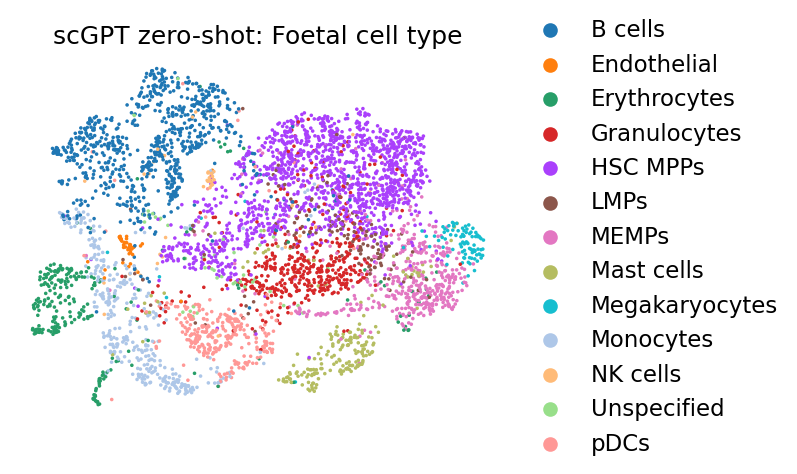

In [4]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)
sc.pl.umap(embed_adata, 
           color=cell_type_key, 
           frameon=False, 
           wspace=0.4, 
           title="scGPT zero-shot: Foetal cell type")

Accuracy calculation by clustering embeddings

K-Means Accuracy: 0.2136
Agglomerative Clustering Accuracy: 0.0102
DBSCAN Accuracy: 0.1680


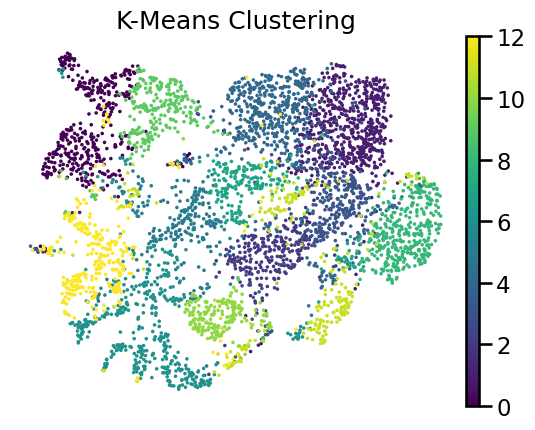

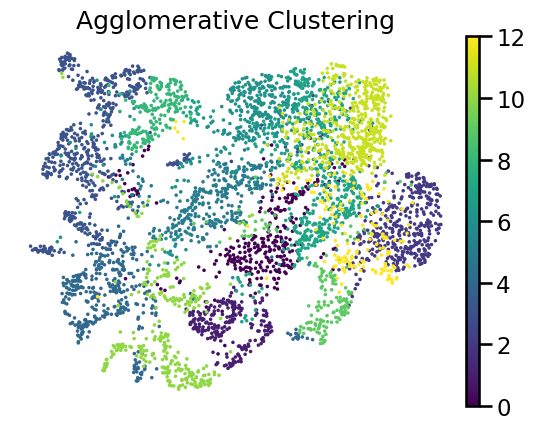

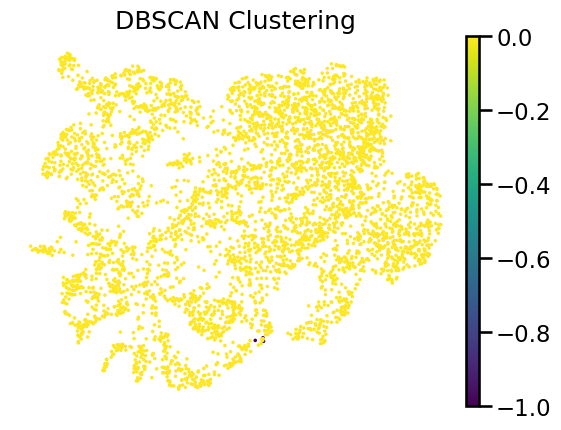

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.preprocessing import LabelEncoder

true_labels = embed_adata.obs[cell_type_key].values
label_encoder = LabelEncoder()
true_labels_int = label_encoder.fit_transform(true_labels)
embed_adata.obs['true_labels_int'] = true_labels_int

model_embeddings = embed_adata.obsm['X_scGPT']
n_clusters = len(embed_adata.obs[cell_type_key].unique())
# K-Means Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(model_embeddings)
embed_adata.obs['kmeans_labels'] = kmeans.labels_

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=n_clusters).fit(model_embeddings)
embed_adata.obs['agglo_labels'] = agglo.labels_

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(model_embeddings)
embed_adata.obs['dbscan_labels'] = dbscan.labels_
kmeans_labels = embed_adata.obs['kmeans_labels'].values
agglo_labels = embed_adata.obs['agglo_labels'].values
dbscan_labels = embed_adata.obs['dbscan_labels'].values

# Calculate accuracy for K-Means
kmeans_accuracy = accuracy_score(true_labels_int, kmeans_labels)
print(f"K-Means Accuracy: {kmeans_accuracy:.4f}")

# Calculate accuracy for Agglomerative Clustering
agglo_accuracy = accuracy_score(true_labels_int, agglo_labels)
print(f"Agglomerative Clustering Accuracy: {agglo_accuracy:.4f}")

# Calculate accuracy for DBSCAN (excluding noise points with label -1)
dbscan_mask = (dbscan_labels != -1)
dbscan_accuracy = accuracy_score(true_labels_int[dbscan_mask], dbscan_labels[dbscan_mask])
print(f"DBSCAN Accuracy: {dbscan_accuracy:.4f}")

# Plot K-Means Clustering
sc.pl.umap(embed_adata, color='kmeans_labels', frameon=False, wspace=0.4, title="K-Means Clustering")

# Plot Agglomerative Clustering
sc.pl.umap(embed_adata, color='agglo_labels', frameon=False, wspace=0.4, title="Agglomerative Clustering")

# Plot DBSCAN Clustering
sc.pl.umap(embed_adata, color='dbscan_labels', frameon=False, wspace=0.4, title="DBSCAN Clustering")

In [9]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.classifier(x)
        return x

input_dim = 512  # Input dimension (same as embedding dimension)
hidden_dim = 512  # Hidden layer dimension
num_classes = len(embed_adata.obs[cell_type_key].unique())  # Number of classes

model = SimpleNN(input_dim, hidden_dim, num_classes).to(device)

# Convert string labels to integers
true_labels = embed_adata.obs[cell_type_key].values
label_encoder = LabelEncoder()
true_labels_int = label_encoder.fit_transform(true_labels)

# Extract model-generated embeddings
model_embeddings = embed_adata.obsm['X_scGPT']

# Convert to PyTorch tensors
X = torch.tensor(model_embeddings, dtype=torch.float32).to(device)
y = torch.tensor(true_labels_int, dtype=torch.long).to(device)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for training set
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create DataLoader for testing set
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, dataloader, criterion, optimizer, max_epochs, convergence_threshold=1e-4):
    model.train()
    previous_loss = float('inf')
    for epoch in range(max_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        current_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{max_epochs}, Loss: {current_loss:.4f}")
        
        # Check for convergence
        if abs(previous_loss - current_loss) < convergence_threshold:
            print("Converged!")
            break
        
        previous_loss = current_loss


# Train the model
max_epochs = 100
train_model(model, train_dataloader, criterion, optimizer, max_epochs)

# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, test_predicted = torch.max(test_outputs, 1)
    test_accuracy = accuracy_score(y_test.cpu().numpy(), test_predicted.cpu().numpy())
    print(f"Test Accuracy: {test_accuracy:.4f}")



Epoch 1/100, Loss: 1.7563
Epoch 2/100, Loss: 0.8406
Epoch 3/100, Loss: 0.5852
Epoch 4/100, Loss: 0.4719
Epoch 5/100, Loss: 0.4462
Epoch 6/100, Loss: 0.4113
Epoch 7/100, Loss: 0.3928
Epoch 8/100, Loss: 0.3590
Epoch 9/100, Loss: 0.3442
Epoch 10/100, Loss: 0.3272
Epoch 11/100, Loss: 0.3105
Epoch 12/100, Loss: 0.3080
Epoch 13/100, Loss: 0.2941
Epoch 14/100, Loss: 0.3063
Epoch 15/100, Loss: 0.2813
Epoch 16/100, Loss: 0.2837
Epoch 17/100, Loss: 0.2674
Epoch 18/100, Loss: 0.2704
Epoch 19/100, Loss: 0.2644
Epoch 20/100, Loss: 0.2515
Epoch 21/100, Loss: 0.2568
Epoch 22/100, Loss: 0.2496
Epoch 23/100, Loss: 0.2447
Epoch 24/100, Loss: 0.2253
Epoch 25/100, Loss: 0.2198
Epoch 26/100, Loss: 0.2325
Epoch 27/100, Loss: 0.2196
Epoch 28/100, Loss: 0.2184
Epoch 29/100, Loss: 0.2121
Epoch 30/100, Loss: 0.2145
Epoch 31/100, Loss: 0.1984
Epoch 32/100, Loss: 0.1970
Epoch 33/100, Loss: 0.1793
Epoch 34/100, Loss: 0.1723
Epoch 35/100, Loss: 0.1774
Epoch 36/100, Loss: 0.1723
Epoch 37/100, Loss: 0.1701
Epoch 38/1

# PBMC

## Prepare the datasets

In [5]:
#PBMC
smaple_data_path = '/home/andreafabbricatore/thesis/data/PBMC.h5ad'
adata = sc.read_h5ad(smaple_data_path)
adata.var['gene_name'] = adata.var.index

gene_col = "gene_name"
cell_type_key = "Label"
batch_key = "sample"
N_HVG = 3000

## Generate the cell embeddings

In [6]:
embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)
# attach the cell embedding to the original adata

scGPT - INFO - match 11552/12762 genes in vocabulary of size 60697.


/home/andreafabbricatore/.local/lib/python3.10/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 220/220 [00:28<00:00,  7.62it/s]
/home/andreafabbricatore/.local/lib/python3.10/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


## Visualize the integration performance

UMAP of scGPT embedding colored by cell type:

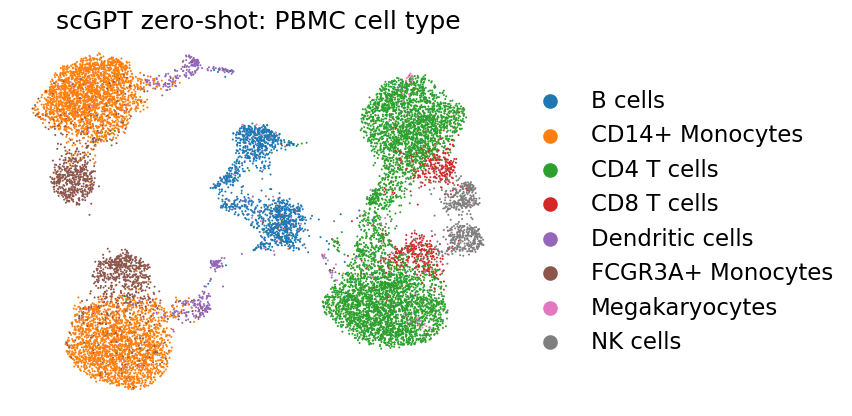

In [7]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)
sc.pl.umap(embed_adata, 
           color=cell_type_key, 
           frameon=False, 
           wspace=0.4, 
           title="scGPT zero-shot: PBMC cell type")

K-Means Accuracy: 0.1610
Agglomerative Clustering Accuracy: 0.0561
DBSCAN Accuracy: 0.0954


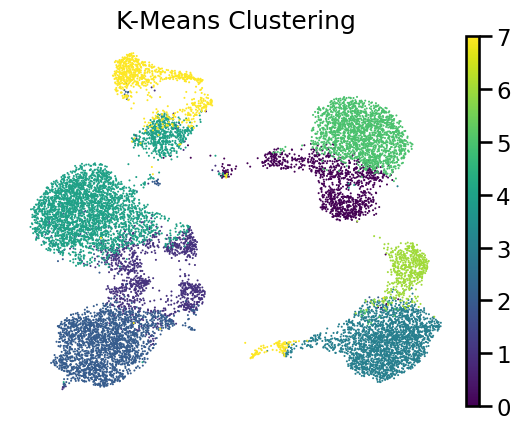

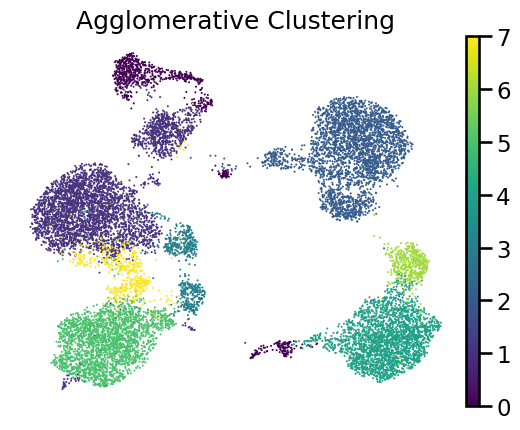

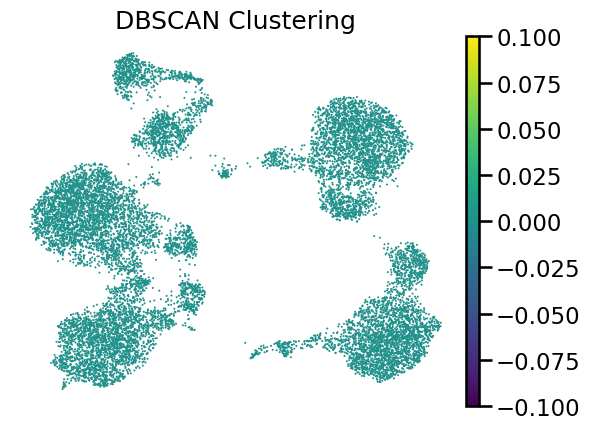

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder

true_labels = embed_adata.obs[cell_type_key].values
label_encoder = LabelEncoder()
true_labels_int = label_encoder.fit_transform(true_labels)
embed_adata.obs['true_labels_int'] = true_labels_int

model_embeddings = embed_adata.obsm['X_scGPT']
n_clusters = len(embed_adata.obs[cell_type_key].unique())
# K-Means Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(model_embeddings)
embed_adata.obs['kmeans_labels'] = kmeans.labels_

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=n_clusters).fit(model_embeddings)
embed_adata.obs['agglo_labels'] = agglo.labels_

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(model_embeddings)
embed_adata.obs['dbscan_labels'] = dbscan.labels_
kmeans_labels = embed_adata.obs['kmeans_labels'].values
agglo_labels = embed_adata.obs['agglo_labels'].values
dbscan_labels = embed_adata.obs['dbscan_labels'].values

# Calculate accuracy for K-Means
kmeans_accuracy = accuracy_score(true_labels_int, kmeans_labels)
print(f"K-Means Accuracy: {kmeans_accuracy:.4f}")

# Calculate accuracy for Agglomerative Clustering
agglo_accuracy = accuracy_score(true_labels_int, agglo_labels)
print(f"Agglomerative Clustering Accuracy: {agglo_accuracy:.4f}")

# Calculate accuracy for DBSCAN (excluding noise points with label -1)
dbscan_mask = (dbscan_labels != -1)
dbscan_accuracy = accuracy_score(true_labels_int[dbscan_mask], dbscan_labels[dbscan_mask])
print(f"DBSCAN Accuracy: {dbscan_accuracy:.4f}")

# Plot K-Means Clustering
sc.pl.umap(embed_adata, color='kmeans_labels', frameon=False, wspace=0.4, title="K-Means Clustering")

# Plot Agglomerative Clustering
sc.pl.umap(embed_adata, color='agglo_labels', frameon=False, wspace=0.4, title="Agglomerative Clustering")

# Plot DBSCAN Clustering
sc.pl.umap(embed_adata, color='dbscan_labels', frameon=False, wspace=0.4, title="DBSCAN Clustering")

In [6]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.classifier(x)
        return x

input_dim = 512  # Input dimension (same as embedding dimension)
hidden_dim = 512  # Hidden layer dimension
num_classes = len(embed_adata.obs[cell_type_key].unique())  # Number of classes

model = SimpleNN(input_dim, hidden_dim, num_classes).to(device)

# Convert string labels to integers
true_labels = embed_adata.obs[cell_type_key].values
label_encoder = LabelEncoder()
true_labels_int = label_encoder.fit_transform(true_labels)

# Extract model-generated embeddings
model_embeddings = embed_adata.obsm['X_scGPT']

# Convert to PyTorch tensors
X = torch.tensor(model_embeddings, dtype=torch.float32).to(device)
y = torch.tensor(true_labels_int, dtype=torch.long).to(device)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for training set
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create DataLoader for testing set
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, dataloader, criterion, optimizer, max_epochs, convergence_threshold=1e-4):
    model.train()
    previous_loss = float('inf')
    for epoch in range(max_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        current_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{max_epochs}, Loss: {current_loss:.4f}")
        
        # Check for convergence
        if abs(previous_loss - current_loss) < convergence_threshold:
            print("Converged!")
            break
        
        previous_loss = current_loss


# Train the model
max_epochs = 100
train_model(model, train_dataloader, criterion, optimizer, max_epochs)

# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, test_predicted = torch.max(test_outputs, 1)
    test_accuracy = accuracy_score(y_test.cpu().numpy(), test_predicted.cpu().numpy())
    print(f"Test Accuracy: {test_accuracy:.4f}")



Epoch 1/100, Loss: 0.7011
Epoch 2/100, Loss: 0.2871
Epoch 3/100, Loss: 0.2480
Epoch 4/100, Loss: 0.2294
Epoch 5/100, Loss: 0.2250
Epoch 6/100, Loss: 0.2108
Epoch 7/100, Loss: 0.2118
Epoch 8/100, Loss: 0.2026
Epoch 9/100, Loss: 0.1991
Epoch 10/100, Loss: 0.1953
Epoch 11/100, Loss: 0.1905
Epoch 12/100, Loss: 0.1909
Epoch 13/100, Loss: 0.1868
Epoch 14/100, Loss: 0.1869
Epoch 15/100, Loss: 0.1826
Epoch 16/100, Loss: 0.1814
Epoch 17/100, Loss: 0.1777
Epoch 18/100, Loss: 0.1793
Epoch 19/100, Loss: 0.1750
Epoch 20/100, Loss: 0.1768
Epoch 21/100, Loss: 0.1660
Epoch 22/100, Loss: 0.1697
Epoch 23/100, Loss: 0.1659
Epoch 24/100, Loss: 0.1693
Epoch 25/100, Loss: 0.1674
Epoch 26/100, Loss: 0.1617
Epoch 27/100, Loss: 0.1578
Epoch 28/100, Loss: 0.1544
Epoch 29/100, Loss: 0.1565
Epoch 30/100, Loss: 0.1529
Epoch 31/100, Loss: 0.1561
Epoch 32/100, Loss: 0.1513
Epoch 33/100, Loss: 0.1449
Epoch 34/100, Loss: 0.1468
Epoch 35/100, Loss: 0.1441
Epoch 36/100, Loss: 0.1467
Epoch 37/100, Loss: 0.1420
Epoch 38/1

# PIC

## Prepare the datasets

In [8]:
#foetal
smaple_data_path = '/home/andreafabbricatore/thesis/data/PIC.h5ad'
adata = sc.read_h5ad(smaple_data_path)
adata.var['gene_name'] = adata.var.index

gene_col = "gene_name"
cell_type_key = "Label"
batch_key = "sample"
N_HVG = 3000

## Generate the cell embeddings

In [9]:
embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)
# attach the cell embedding to the original adata

scGPT - INFO - match 25278/34363 genes in vocabulary of size 60697.


/home/andreafabbricatore/.local/lib/python3.10/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 99/99 [00:14<00:00,  6.65it/s]
/home/andreafabbricatore/.local/lib/python3.10/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


## Visualize the integration performance

UMAP of scGPT embedding colored by cell type:

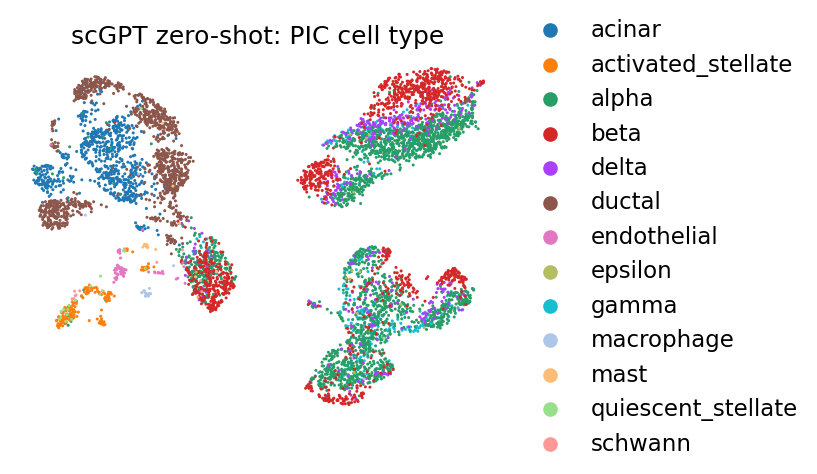

In [10]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)
sc.pl.umap(embed_adata, 
           color=cell_type_key, 
           frameon=False, 
           wspace=0.4, 
           title="scGPT zero-shot: PIC cell type")

K-Means Accuracy: 0.1614
Agglomerative Clustering Accuracy: 0.1043
DBSCAN Accuracy: 0.1125


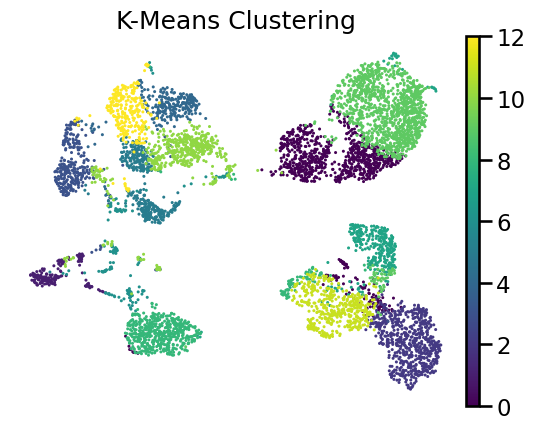

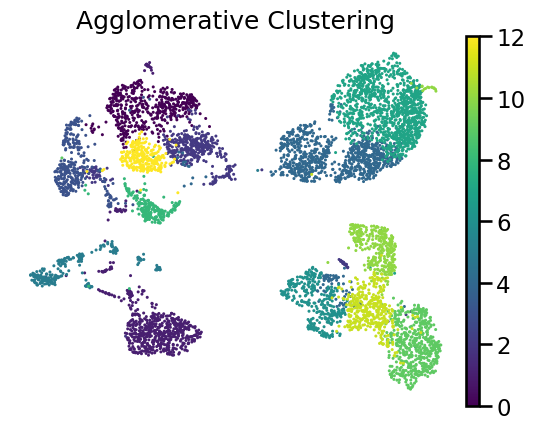

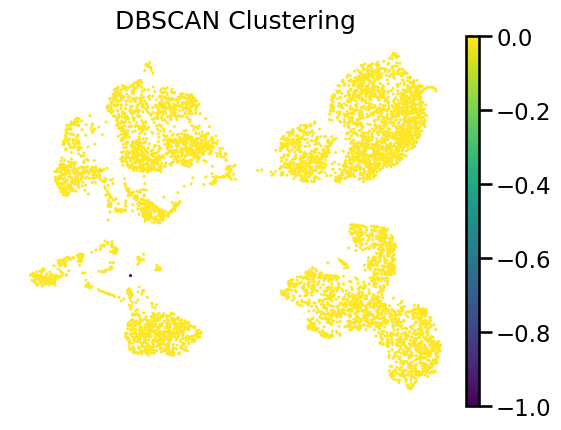

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder

true_labels = embed_adata.obs[cell_type_key].values
label_encoder = LabelEncoder()
true_labels_int = label_encoder.fit_transform(true_labels)
embed_adata.obs['true_labels_int'] = true_labels_int

model_embeddings = embed_adata.obsm['X_scGPT']
n_clusters = len(embed_adata.obs[cell_type_key].unique())
# K-Means Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(model_embeddings)
embed_adata.obs['kmeans_labels'] = kmeans.labels_

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=n_clusters).fit(model_embeddings)
embed_adata.obs['agglo_labels'] = agglo.labels_

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(model_embeddings)
embed_adata.obs['dbscan_labels'] = dbscan.labels_
kmeans_labels = embed_adata.obs['kmeans_labels'].values
agglo_labels = embed_adata.obs['agglo_labels'].values
dbscan_labels = embed_adata.obs['dbscan_labels'].values

# Calculate accuracy for K-Means
kmeans_accuracy = accuracy_score(true_labels_int, kmeans_labels)
print(f"K-Means Accuracy: {kmeans_accuracy:.4f}")

# Calculate accuracy for Agglomerative Clustering
agglo_accuracy = accuracy_score(true_labels_int, agglo_labels)
print(f"Agglomerative Clustering Accuracy: {agglo_accuracy:.4f}")

# Calculate accuracy for DBSCAN (excluding noise points with label -1)
dbscan_mask = (dbscan_labels != -1)
dbscan_accuracy = accuracy_score(true_labels_int[dbscan_mask], dbscan_labels[dbscan_mask])
print(f"DBSCAN Accuracy: {dbscan_accuracy:.4f}")

# Plot K-Means Clustering
sc.pl.umap(embed_adata, color='kmeans_labels', frameon=False, wspace=0.4, title="K-Means Clustering")

# Plot Agglomerative Clustering
sc.pl.umap(embed_adata, color='agglo_labels', frameon=False, wspace=0.4, title="Agglomerative Clustering")

# Plot DBSCAN Clustering
sc.pl.umap(embed_adata, color='dbscan_labels', frameon=False, wspace=0.4, title="DBSCAN Clustering")

In [11]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.classifier(x)
        return x

input_dim = 512  # Input dimension (same as embedding dimension)
hidden_dim = 512  # Hidden layer dimension
num_classes = len(embed_adata.obs[cell_type_key].unique())  # Number of classes

model = SimpleNN(input_dim, hidden_dim, num_classes).to(device)

# Convert string labels to integers
true_labels = embed_adata.obs[cell_type_key].values
label_encoder = LabelEncoder()
true_labels_int = label_encoder.fit_transform(true_labels)

# Extract model-generated embeddings
model_embeddings = embed_adata.obsm['X_scGPT']

# Convert to PyTorch tensors
X = torch.tensor(model_embeddings, dtype=torch.float32).to(device)
y = torch.tensor(true_labels_int, dtype=torch.long).to(device)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for training set
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create DataLoader for testing set
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, dataloader, criterion, optimizer, max_epochs, convergence_threshold=1e-4):
    model.train()
    previous_loss = float('inf')
    for epoch in range(max_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        current_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{max_epochs}, Loss: {current_loss:.4f}")
        
        # Check for convergence
        if abs(previous_loss - current_loss) < convergence_threshold:
            print("Converged!")
            break
        
        previous_loss = current_loss


# Train the model
max_epochs = 100
train_model(model, train_dataloader, criterion, optimizer, max_epochs)

# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, test_predicted = torch.max(test_outputs, 1)
    test_accuracy = accuracy_score(y_test.cpu().numpy(), test_predicted.cpu().numpy())
    print(f"Test Accuracy: {test_accuracy:.4f}")



Epoch 1/100, Loss: 1.3604
Epoch 2/100, Loss: 0.6110
Epoch 3/100, Loss: 0.5348
Epoch 4/100, Loss: 0.4926
Epoch 5/100, Loss: 0.4495
Epoch 6/100, Loss: 0.4186
Epoch 7/100, Loss: 0.4069
Epoch 8/100, Loss: 0.3773
Epoch 9/100, Loss: 0.3595
Epoch 10/100, Loss: 0.3525
Epoch 11/100, Loss: 0.3224
Epoch 12/100, Loss: 0.3176
Epoch 13/100, Loss: 0.3141
Epoch 14/100, Loss: 0.3020
Epoch 15/100, Loss: 0.2993
Epoch 16/100, Loss: 0.2808
Epoch 17/100, Loss: 0.2704
Epoch 18/100, Loss: 0.2694
Epoch 19/100, Loss: 0.2658
Epoch 20/100, Loss: 0.2581
Epoch 21/100, Loss: 0.2574
Epoch 22/100, Loss: 0.2573
Converged!
Test Accuracy: 0.8838


# Hypoxia

## Prepare the datasets

In [11]:
#foetal
smaple_data_path = '/home/andreafabbricatore/thesis/data/scsHypoxia_filtered.h5ad'
adata = sc.read_h5ad(smaple_data_path)
adata.var['gene_name'] = adata.var.index

gene_col = "gene_name"
cell_type_key = "Label"
batch_key = "sample"
N_HVG = 3000

## Generate the cell embeddings

In [12]:
embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)
# attach the cell embedding to the original adata

scGPT - INFO - match 16018/19046 genes in vocabulary of size 60697.


/home/andreafabbricatore/.local/lib/python3.10/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 145/145 [00:20<00:00,  6.93it/s]
/home/andreafabbricatore/.local/lib/python3.10/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


## Visualize the integration performance

UMAP of scGPT embedding colored by cell type:

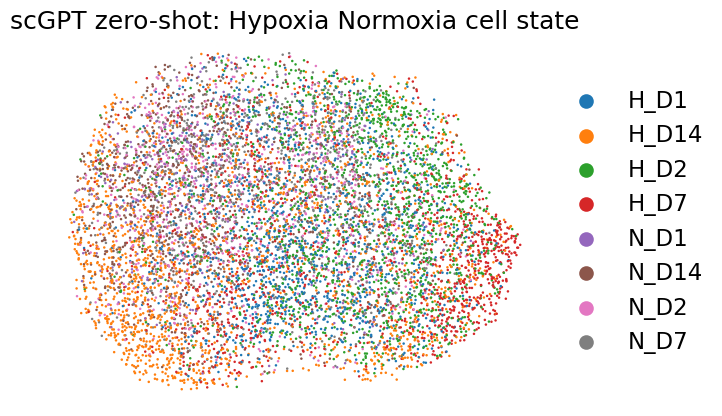

In [14]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)
sc.pl.umap(embed_adata, 
           color=cell_type_key, 
           frameon=False, 
           wspace=0.4, 
           title="scGPT zero-shot: Hypoxia Normoxia cell state")

K-Means Accuracy: 0.1197
Agglomerative Clustering Accuracy: 0.1011
DBSCAN Accuracy: 0.1478


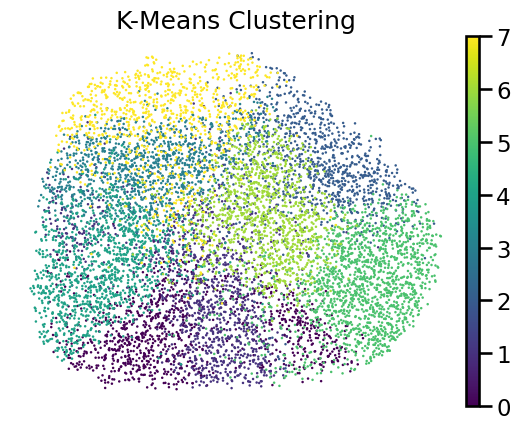

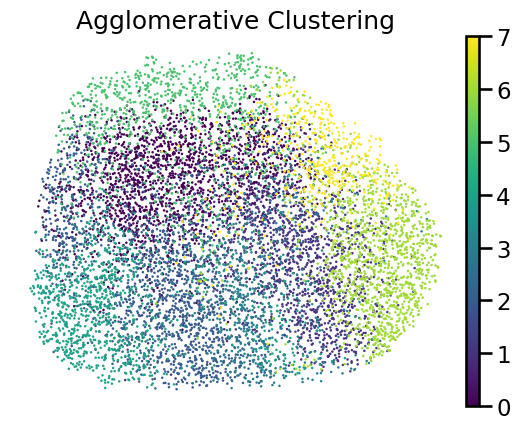

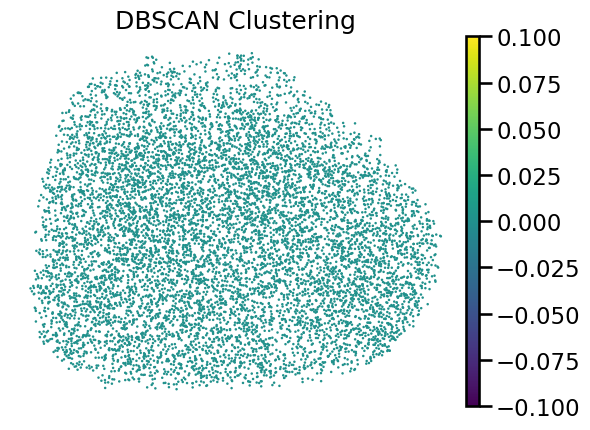

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder

true_labels = embed_adata.obs[cell_type_key].values
label_encoder = LabelEncoder()
true_labels_int = label_encoder.fit_transform(true_labels)
embed_adata.obs['true_labels_int'] = true_labels_int

model_embeddings = embed_adata.obsm['X_scGPT']
n_clusters = len(embed_adata.obs[cell_type_key].unique())
# K-Means Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(model_embeddings)
embed_adata.obs['kmeans_labels'] = kmeans.labels_

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=n_clusters).fit(model_embeddings)
embed_adata.obs['agglo_labels'] = agglo.labels_

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(model_embeddings)
embed_adata.obs['dbscan_labels'] = dbscan.labels_
kmeans_labels = embed_adata.obs['kmeans_labels'].values
agglo_labels = embed_adata.obs['agglo_labels'].values
dbscan_labels = embed_adata.obs['dbscan_labels'].values

# Calculate accuracy for K-Means
kmeans_accuracy = accuracy_score(true_labels_int, kmeans_labels)
print(f"K-Means Accuracy: {kmeans_accuracy:.4f}")

# Calculate accuracy for Agglomerative Clustering
agglo_accuracy = accuracy_score(true_labels_int, agglo_labels)
print(f"Agglomerative Clustering Accuracy: {agglo_accuracy:.4f}")

# Calculate accuracy for DBSCAN (excluding noise points with label -1)
dbscan_mask = (dbscan_labels != -1)
dbscan_accuracy = accuracy_score(true_labels_int[dbscan_mask], dbscan_labels[dbscan_mask])
print(f"DBSCAN Accuracy: {dbscan_accuracy:.4f}")

# Plot K-Means Clustering
sc.pl.umap(embed_adata, color='kmeans_labels', frameon=False, wspace=0.4, title="K-Means Clustering")

# Plot Agglomerative Clustering
sc.pl.umap(embed_adata, color='agglo_labels', frameon=False, wspace=0.4, title="Agglomerative Clustering")

# Plot DBSCAN Clustering
sc.pl.umap(embed_adata, color='dbscan_labels', frameon=False, wspace=0.4, title="DBSCAN Clustering")

In [16]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.classifier(x)
        return x

input_dim = 512  # Input dimension (same as embedding dimension)
hidden_dim = 512  # Hidden layer dimension
num_classes = len(embed_adata.obs[cell_type_key].unique())  # Number of classes

model = SimpleNN(input_dim, hidden_dim, num_classes).to(device)

# Convert string labels to integers
true_labels = embed_adata.obs[cell_type_key].values
label_encoder = LabelEncoder()
true_labels_int = label_encoder.fit_transform(true_labels)

# Extract model-generated embeddings
model_embeddings = embed_adata.obsm['X_scGPT']

# Convert to PyTorch tensors
X = torch.tensor(model_embeddings, dtype=torch.float32).to(device)
y = torch.tensor(true_labels_int, dtype=torch.long).to(device)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for training set
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create DataLoader for testing set
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, dataloader, criterion, optimizer, max_epochs, convergence_threshold=1e-4):
    model.train()
    previous_loss = float('inf')
    for epoch in range(max_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        current_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{max_epochs}, Loss: {current_loss:.4f}")
        
        # Check for convergence
        if abs(previous_loss - current_loss) < convergence_threshold:
            print("Converged!")
            break
        
        previous_loss = current_loss


# Train the model
max_epochs = 100
train_model(model, train_dataloader, criterion, optimizer, max_epochs)

# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, test_predicted = torch.max(test_outputs, 1)
    test_accuracy = accuracy_score(y_test.cpu().numpy(), test_predicted.cpu().numpy())
    print(f"Test Accuracy: {test_accuracy:.4f}")



Epoch 1/100, Loss: 1.7672
Epoch 2/100, Loss: 1.4460
Epoch 3/100, Loss: 1.3490
Epoch 4/100, Loss: 1.2897
Epoch 5/100, Loss: 1.2528
Epoch 6/100, Loss: 1.2315
Epoch 7/100, Loss: 1.2098
Epoch 8/100, Loss: 1.1775
Epoch 9/100, Loss: 1.1715
Epoch 10/100, Loss: 1.1420
Epoch 11/100, Loss: 1.1564
Epoch 12/100, Loss: 1.1260
Epoch 13/100, Loss: 1.1323
Epoch 14/100, Loss: 1.1104
Epoch 15/100, Loss: 1.1088
Epoch 16/100, Loss: 1.1011
Epoch 17/100, Loss: 1.0933
Epoch 18/100, Loss: 1.0820
Epoch 19/100, Loss: 1.0724
Epoch 20/100, Loss: 1.0585
Epoch 21/100, Loss: 1.0548
Epoch 22/100, Loss: 1.0510
Epoch 23/100, Loss: 1.0480
Epoch 24/100, Loss: 1.0406
Epoch 25/100, Loss: 1.0250
Epoch 26/100, Loss: 1.0300
Epoch 27/100, Loss: 1.0108
Epoch 28/100, Loss: 1.0018
Epoch 29/100, Loss: 0.9928
Epoch 30/100, Loss: 0.9911
Epoch 31/100, Loss: 0.9888
Epoch 32/100, Loss: 0.9766
Epoch 33/100, Loss: 0.9618
Epoch 34/100, Loss: 0.9579
Epoch 35/100, Loss: 0.9563
Epoch 36/100, Loss: 0.9237
Epoch 37/100, Loss: 0.9225
Epoch 38/1

In [19]:
count = 0
total = 0
for i,j in enumerate(y_test):
    if j < 4:
        total += 1
        if j == test_predicted[i]:
            count += 1
print(len(test_outputs))
print(total)
print(f"Accuracy: {count/total}")

1847
1186
Accuracy: 0.663575042158516


# Hypoxia only

## Prepare the datasets

In [15]:
#foetal
smaple_data_path = '/home/andreafabbricatore/thesis/data/scs_only_Hypoxia_filtered.h5ad'
adata = sc.read_h5ad(smaple_data_path)
adata.var['gene_name'] = adata.var.index

gene_col = "gene_name"
cell_type_key = "Label"
batch_key = "sample"
N_HVG = 3000

## Generate the cell embeddings

In [18]:
embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)
# attach the cell embedding to the original adata

scGPT - INFO - match 16018/19046 genes in vocabulary of size 60697.


/home/andreafabbricatore/.local/lib/python3.10/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 94/94 [00:13<00:00,  6.86it/s]
/home/andreafabbricatore/.local/lib/python3.10/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


## Visualize the integration performance

UMAP of scGPT embedding colored by cell type:

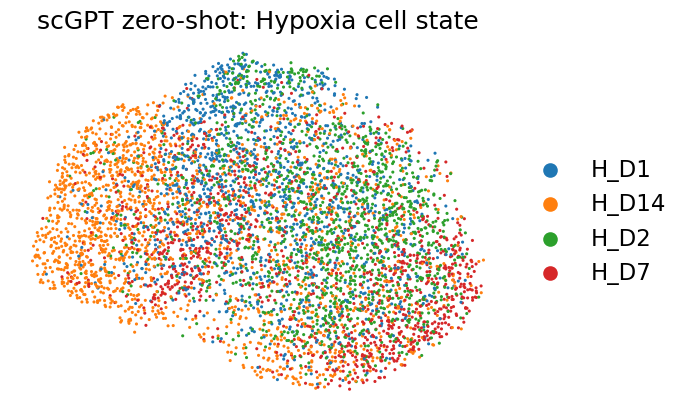

In [19]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)
sc.pl.umap(embed_adata, 
           color=cell_type_key, 
           frameon=False, 
           wspace=0.4, 
           title="scGPT zero-shot: Hypoxia cell state")

K-Means Accuracy: 0.2540
Agglomerative Clustering Accuracy: 0.3412
DBSCAN Accuracy: 0.2278


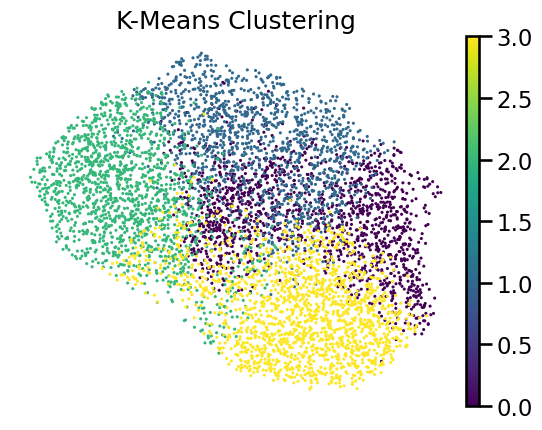

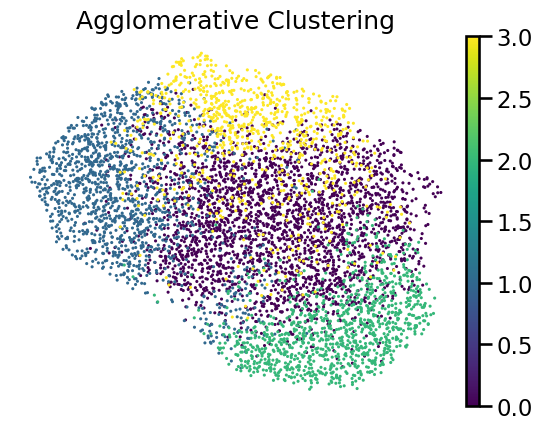

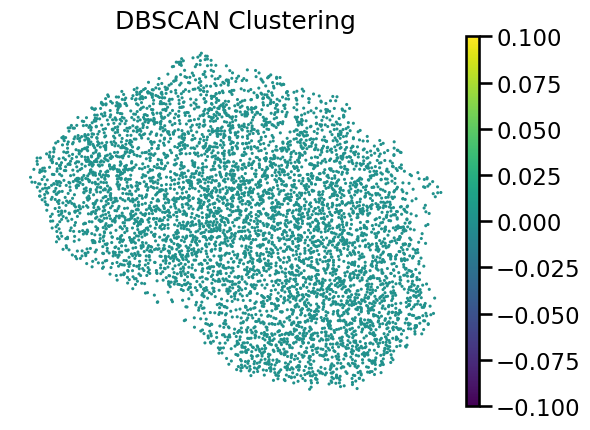

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder

true_labels = embed_adata.obs[cell_type_key].values
label_encoder = LabelEncoder()
true_labels_int = label_encoder.fit_transform(true_labels)
embed_adata.obs['true_labels_int'] = true_labels_int

model_embeddings = embed_adata.obsm['X_scGPT']
n_clusters = len(embed_adata.obs[cell_type_key].unique())
# K-Means Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(model_embeddings)
embed_adata.obs['kmeans_labels'] = kmeans.labels_

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=n_clusters).fit(model_embeddings)
embed_adata.obs['agglo_labels'] = agglo.labels_

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(model_embeddings)
embed_adata.obs['dbscan_labels'] = dbscan.labels_
kmeans_labels = embed_adata.obs['kmeans_labels'].values
agglo_labels = embed_adata.obs['agglo_labels'].values
dbscan_labels = embed_adata.obs['dbscan_labels'].values

# Calculate accuracy for K-Means
kmeans_accuracy = accuracy_score(true_labels_int, kmeans_labels)
print(f"K-Means Accuracy: {kmeans_accuracy:.4f}")

# Calculate accuracy for Agglomerative Clustering
agglo_accuracy = accuracy_score(true_labels_int, agglo_labels)
print(f"Agglomerative Clustering Accuracy: {agglo_accuracy:.4f}")

# Calculate accuracy for DBSCAN (excluding noise points with label -1)
dbscan_mask = (dbscan_labels != -1)
dbscan_accuracy = accuracy_score(true_labels_int[dbscan_mask], dbscan_labels[dbscan_mask])
print(f"DBSCAN Accuracy: {dbscan_accuracy:.4f}")

# Plot K-Means Clustering
sc.pl.umap(embed_adata, color='kmeans_labels', frameon=False, wspace=0.4, title="K-Means Clustering")

# Plot Agglomerative Clustering
sc.pl.umap(embed_adata, color='agglo_labels', frameon=False, wspace=0.4, title="Agglomerative Clustering")

# Plot DBSCAN Clustering
sc.pl.umap(embed_adata, color='dbscan_labels', frameon=False, wspace=0.4, title="DBSCAN Clustering")

In [24]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.classifier(x)
        return x

input_dim = 512  # Input dimension (same as embedding dimension)
hidden_dim = 512  # Hidden layer dimension
num_classes = len(embed_adata.obs[cell_type_key].unique())  # Number of classes

model = SimpleNN(input_dim, hidden_dim, num_classes).to(device)

# Convert string labels to integers
true_labels = embed_adata.obs[cell_type_key].values
label_encoder = LabelEncoder()
true_labels_int = label_encoder.fit_transform(true_labels)

# Extract model-generated embeddings
model_embeddings = embed_adata.obsm['X_scGPT']

# Convert to PyTorch tensors
X = torch.tensor(model_embeddings, dtype=torch.float32).to(device)
y = torch.tensor(true_labels_int, dtype=torch.long).to(device)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for training set
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create DataLoader for testing set
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, dataloader, criterion, optimizer, max_epochs, convergence_threshold=1e-4):
    model.train()
    previous_loss = float('inf')
    for epoch in range(max_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        current_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{max_epochs}, Loss: {current_loss:.4f}")
        
        # Check for convergence
        if abs(previous_loss - current_loss) < convergence_threshold:
            print("Converged!")
            break
        
        previous_loss = current_loss


# Train the model
max_epochs = 100
train_model(model, train_dataloader, criterion, optimizer, max_epochs)

# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, test_predicted = torch.max(test_outputs, 1)
    test_accuracy = accuracy_score(y_test.cpu().numpy(), test_predicted.cpu().numpy())
    print(f"Test Accuracy: {test_accuracy:.4f}")



Epoch 1/100, Loss: 1.1176
Epoch 2/100, Loss: 0.8539
Epoch 3/100, Loss: 0.7892
Epoch 4/100, Loss: 0.7734
Epoch 5/100, Loss: 0.7517
Epoch 6/100, Loss: 0.7439
Epoch 7/100, Loss: 0.7074
Epoch 8/100, Loss: 0.6999
Epoch 9/100, Loss: 0.6997
Epoch 10/100, Loss: 0.6893
Epoch 11/100, Loss: 0.6732
Epoch 12/100, Loss: 0.6632
Epoch 13/100, Loss: 0.6599
Epoch 14/100, Loss: 0.6412
Epoch 15/100, Loss: 0.6341
Epoch 16/100, Loss: 0.6371
Epoch 17/100, Loss: 0.6305
Epoch 18/100, Loss: 0.6117
Epoch 19/100, Loss: 0.6169
Epoch 20/100, Loss: 0.6068
Epoch 21/100, Loss: 0.6011
Epoch 22/100, Loss: 0.5987
Epoch 23/100, Loss: 0.5697
Epoch 24/100, Loss: 0.5683
Epoch 25/100, Loss: 0.5797
Epoch 26/100, Loss: 0.5679
Epoch 27/100, Loss: 0.5476
Epoch 28/100, Loss: 0.5546
Epoch 29/100, Loss: 0.5346
Epoch 30/100, Loss: 0.5265
Epoch 31/100, Loss: 0.5336
Epoch 32/100, Loss: 0.5064
Epoch 33/100, Loss: 0.5092
Epoch 34/100, Loss: 0.4966
Epoch 35/100, Loss: 0.4789
Epoch 36/100, Loss: 0.4709
Epoch 37/100, Loss: 0.4924
Epoch 38/1

# Hypoxia vs Normoxia (sanity check)

## Prepare the datasets

In [26]:
#foetal
smaple_data_path = '/home/andreafabbricatore/thesis/data/scsHypoxia_filtered.h5ad'
adata = sc.read_h5ad(smaple_data_path)
adata.var['gene_name'] = adata.var.index

gene_col = "gene_name"
cell_type_key = "HypoxicState"
batch_key = "sample"
N_HVG = 3000

## Generate the cell embeddings

In [27]:
embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)
# attach the cell embedding to the original adata

scGPT - INFO - match 16018/19046 genes in vocabulary of size 60697.


/home/andreafabbricatore/.local/lib/python3.10/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 145/145 [00:22<00:00,  6.35it/s]
/home/andreafabbricatore/.local/lib/python3.10/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


## Visualize the integration performance

UMAP of scGPT embedding colored by cell type:

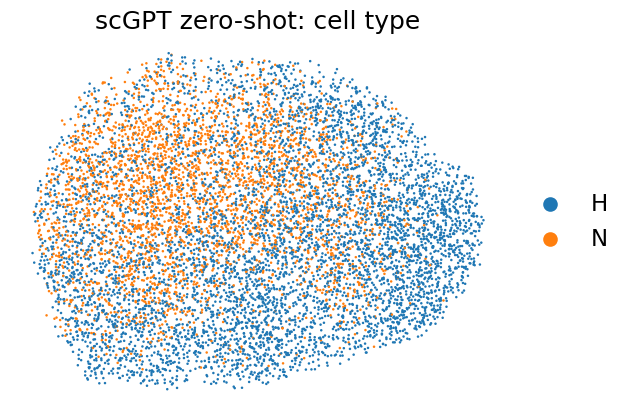

In [28]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)
sc.pl.umap(embed_adata, 
           color=cell_type_key, 
           frameon=False, 
           wspace=0.4, 
           title="scGPT zero-shot: cell type")

K-Means Accuracy: 0.6615
Agglomerative Clustering Accuracy: 0.6202
DBSCAN Accuracy: 0.6488


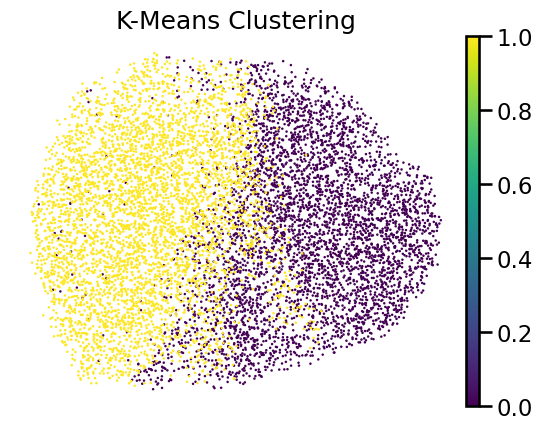

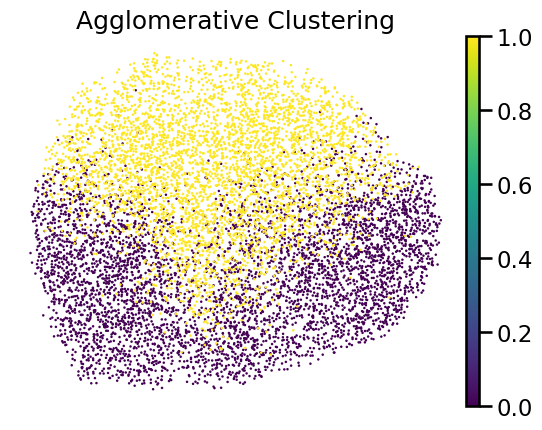

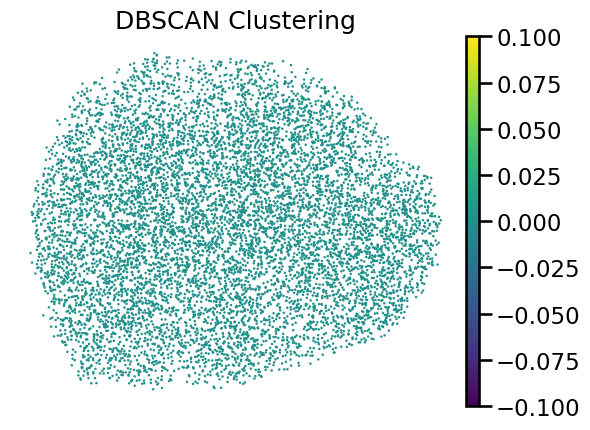

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder

true_labels = embed_adata.obs[cell_type_key].values
label_encoder = LabelEncoder()
true_labels_int = label_encoder.fit_transform(true_labels)
embed_adata.obs['true_labels_int'] = true_labels_int

model_embeddings = embed_adata.obsm['X_scGPT']
n_clusters = len(embed_adata.obs[cell_type_key].unique())
# K-Means Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(model_embeddings)
embed_adata.obs['kmeans_labels'] = kmeans.labels_

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=n_clusters).fit(model_embeddings)
embed_adata.obs['agglo_labels'] = agglo.labels_

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(model_embeddings)
embed_adata.obs['dbscan_labels'] = dbscan.labels_
kmeans_labels = embed_adata.obs['kmeans_labels'].values
agglo_labels = embed_adata.obs['agglo_labels'].values
dbscan_labels = embed_adata.obs['dbscan_labels'].values

# Calculate accuracy for K-Means
kmeans_accuracy = accuracy_score(true_labels_int, kmeans_labels)
print(f"K-Means Accuracy: {kmeans_accuracy:.4f}")

# Calculate accuracy for Agglomerative Clustering
agglo_accuracy = accuracy_score(true_labels_int, agglo_labels)
print(f"Agglomerative Clustering Accuracy: {agglo_accuracy:.4f}")

# Calculate accuracy for DBSCAN (excluding noise points with label -1)
dbscan_mask = (dbscan_labels != -1)
dbscan_accuracy = accuracy_score(true_labels_int[dbscan_mask], dbscan_labels[dbscan_mask])
print(f"DBSCAN Accuracy: {dbscan_accuracy:.4f}")

# Plot K-Means Clustering
sc.pl.umap(embed_adata, color='kmeans_labels', frameon=False, wspace=0.4, title="K-Means Clustering")

# Plot Agglomerative Clustering
sc.pl.umap(embed_adata, color='agglo_labels', frameon=False, wspace=0.4, title="Agglomerative Clustering")

# Plot DBSCAN Clustering
sc.pl.umap(embed_adata, color='dbscan_labels', frameon=False, wspace=0.4, title="DBSCAN Clustering")

In [31]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.classifier(x)
        return x

input_dim = 512  # Input dimension (same as embedding dimension)
hidden_dim = 512  # Hidden layer dimension
num_classes = len(embed_adata.obs[cell_type_key].unique())  # Number of classes

model = SimpleNN(input_dim, hidden_dim, num_classes).to(device)

# Convert string labels to integers
true_labels = embed_adata.obs[cell_type_key].values
label_encoder = LabelEncoder()
true_labels_int = label_encoder.fit_transform(true_labels)

# Extract model-generated embeddings
model_embeddings = embed_adata.obsm['X_scGPT']

# Convert to PyTorch tensors
X = torch.tensor(model_embeddings, dtype=torch.float32).to(device)
y = torch.tensor(true_labels_int, dtype=torch.long).to(device)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for training set
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create DataLoader for testing set
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, dataloader, criterion, optimizer, max_epochs, convergence_threshold=1e-4):
    model.train()
    previous_loss = float('inf')
    for epoch in range(max_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        current_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{max_epochs}, Loss: {current_loss:.4f}")
        
        # Check for convergence
        if abs(previous_loss - current_loss) < convergence_threshold:
            print("Converged!")
            break
        
        previous_loss = current_loss


# Train the model
max_epochs = 200
train_model(model, train_dataloader, criterion, optimizer, max_epochs)

# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, test_predicted = torch.max(test_outputs, 1)
    test_accuracy = accuracy_score(y_test.cpu().numpy(), test_predicted.cpu().numpy())
    print(f"Test Accuracy: {test_accuracy:.4f}")



Epoch 1/200, Loss: 0.4709
Epoch 2/200, Loss: 0.3699
Epoch 3/200, Loss: 0.3523
Epoch 4/200, Loss: 0.3353
Epoch 5/200, Loss: 0.3132
Epoch 6/200, Loss: 0.3125
Epoch 7/200, Loss: 0.3156
Epoch 8/200, Loss: 0.3060
Epoch 9/200, Loss: 0.3091
Epoch 10/200, Loss: 0.2987
Epoch 11/200, Loss: 0.2996
Epoch 12/200, Loss: 0.2955
Epoch 13/200, Loss: 0.2900
Epoch 14/200, Loss: 0.2926
Epoch 15/200, Loss: 0.2863
Epoch 16/200, Loss: 0.2815
Epoch 17/200, Loss: 0.2790
Epoch 18/200, Loss: 0.2926
Epoch 19/200, Loss: 0.2799
Epoch 20/200, Loss: 0.2774
Epoch 21/200, Loss: 0.2724
Epoch 22/200, Loss: 0.2793
Epoch 23/200, Loss: 0.2664
Epoch 24/200, Loss: 0.2761
Epoch 25/200, Loss: 0.2709
Epoch 26/200, Loss: 0.2677
Epoch 27/200, Loss: 0.2666
Epoch 28/200, Loss: 0.2638
Epoch 29/200, Loss: 0.2574
Epoch 30/200, Loss: 0.2596
Epoch 31/200, Loss: 0.2554
Epoch 32/200, Loss: 0.2515
Epoch 33/200, Loss: 0.2522
Epoch 34/200, Loss: 0.2565
Epoch 35/200, Loss: 0.2531
Epoch 36/200, Loss: 0.2435
Epoch 37/200, Loss: 0.2586
Epoch 38/2